In [14]:
import os
import sys

# The original project_root path was for a local Windows machine and caused an error.
# In Colab, we can directly access files uploaded to /content.
# project_root = r"C:\Users\SOUMIK\Downloads\infosys_internship-main\infosys_internship-main"
# os.chdir(project_root)
# print(f"✓ Working directory: {os.getcwd()}")

import pandas as pd
import numpy as np

# Load the cleaned dataset (local file)
cleaned_file = "/content/cleaned_indian_property.csv" # Updated path for Colab
if not os.path.exists(cleaned_file):
    print(f"❌ Error: {cleaned_file} not found.")
    print(f"   Please ensure 'cleaned_indian_property.csv' is uploaded to /content/")
    sys.exit(1)

df = pd.read_csv(cleaned_file, encoding="latin1")
print(f"✓ Loaded {cleaned_file}: {df.shape}")

❌ Error: /content/cleaned_indian_property.csv not found.
   Please ensure 'cleaned_indian_property.csv' is uploaded to /content/


SystemExit: 1

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings("ignore")

# Boosters
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings("ignore")

# Boosters
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [ ]:
df.columns = df.columns.str.strip().str.lower()
print(f"✓ Dataset shape: {df.shape}")
print(f"✓ Columns: {list(df.columns)[:10]}...")  # Show first 10 columns
print(f"\n Data info:")
print(df.info())

✓ Dataset shape: (112890, 32)
✓ Columns: ['property_id', 'property_type', 'property_status', 'price_per_unit_area', 'posted_on', 'project_url', 'property_building_status', 'city_id', 'city_name', 'no_of_bhk']...

 Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112890 entries, 0 to 112889
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   property_id               112890 non-null  int64  
 1   property_type             112890 non-null  object 
 2   property_status           101126 non-null  object 
 3   price_per_unit_area       112890 non-null  object 
 4   posted_on                 112890 non-null  object 
 5   project_url               112890 non-null  object 
 6   property_building_status  112890 non-null  object 
 7   city_id                   112890 non-null  int64  
 8   city_name                 112890 non-null  object 
 9   no_of_bhk                 112890 non-null  

In [ ]:
# Validate core numeric columns exist
for col in ["price_num", "area_num", "price_per_sqft"]:
    if col not in df.columns:
        print(f"❌ Error: {col} not found in dataset")
        print(f"   Available columns: {list(df.columns)}")
        sys.exit(1)
print("✓ Core columns validated")

# Create BHK numeric if needed
if "bhk" not in df.columns:
    if "no_of_bhk" in df.columns:
        df["bhk"] = df["no_of_bhk"].astype(str).str.extract(r'(\d+)')[0].astype(float)
    else:
        print("❌ Warning: BHK column not found, using default value of 2")
        df["bhk"] = 2.0

# Remove invalid BHK values
df = df[df["bhk"].notna() & (df["bhk"] > 0)]
print(f"✓ BHK data cleaned: {df.shape[0]} rows remain")

✓ Core columns validated
✓ BHK data cleaned: 83120 rows remain


In [ ]:
# coerce core numerics
df["area_num"] = pd.to_numeric(df["area_num"], errors="coerce")
df["price_num"] = pd.to_numeric(df["price_num"], errors="coerce")
df = df.dropna(subset=["area_num", "price_num"])

# ---------- 4. High-value feature engineering ----------
# price per sqft (if not present)
if "price_per_sqft" not in df.columns:
    df["price_per_sqft"] = df["price_num"] / df["area_num"]

# basic derived features
df["price_per_bhk"] = df["price_num"] / df["bhk"]
df["area_per_bhk"] = df["area_num"] / df["bhk"]

In [ ]:
# Handle bath column
if "bath" in df.columns:
    df["bath"] = pd.to_numeric(df["bath"], errors="coerce").fillna(df["bhk"])
else:
    df["bath"] = df["bhk"]  # fallback: use BHK as bath count
df["price_per_bath"] = df["price_num"] / (df["bath"] + 1)

# Demand density (listings per locality)
if "locality_name" in df.columns:
    locality_counts = df["locality_name"].value_counts().to_dict()
    df["demand_density"] = df["locality_name"].map(locality_counts).fillna(0).astype(int)
else:
    print("⚠️  locality_name not found, setting demand_density to 0")
    df["demand_density"] = 0

print(f"✓ Bath and demand_density features created")

✓ Bath and demand_density features created


In [ ]:
# Price deviation by locality
if "locality_name" in df.columns:
    local_mean = df.groupby("locality_name")["price_per_sqft"].transform("mean")
    df["price_dev_locality"] = df["price_per_sqft"] - local_mean
else:
    df["price_dev_locality"] = 0

# Luxury index (if required columns exist)
df["is_furnished"] = df.get("is_furnished", 0).astype(str).str.lower().map(
    {"furnished":1,"unfurnished":0,"semi-furnished":0})
df["is_furnished"] = df["is_furnished"].fillna(0).astype(int)
df["is_rera_registered"] = df.get("is_rera_registered", 0).fillna(0).astype(int)
df["is_apartment"] = df.get("is_apartment", 0).fillna(0).astype(int)
df["listing_domain_score"] = df.get("listing_domain_score", 0).fillna(0)

df["luxury_index"] = (df["bath"]/df["bhk"]).fillna(0) + df["is_furnished"] + df["listing_domain_score"]

# Area category
df["area_cat"] = pd.cut(df["area_num"], bins=[0,1000,2000,1e9], labels=["small","medium","large"])

# Distance from city center (haversine if lat/lon available)
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2.0)**2
    return R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

city_centers = {
    "bangalore": (12.9716, 77.5946),
    "mumbai": (19.0760, 72.8777),
    "delhi": (28.6139, 77.2090),
    "chennai": (13.0827, 80.2707),
    "hyderabad": (17.3850, 78.4867),
    "kolkata": (22.5726, 88.3639),
    "lucknow": (26.8467, 80.9462)
}

if "latitude" in df.columns and "longitude" in df.columns:
    df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
    df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")
    def compute_dist(row):
        city = str(row.get("city_name","")).lower()
        lat = row["latitude"]; lon = row["longitude"]
        for k,(clat,clon) in city_centers.items():
            if k in city:
                return haversine_km(lat, lon, clat, clon)
        return np.nan
    df["dist_city_center"] = df.apply(lambda r: compute_dist(r) if pd.notna(r.get("latitude")) and pd.notna(r.get("longitude")) else np.nan, axis=1)
else:
    df["dist_city_center"] = np.nan

# Fill NA distances with median
df["dist_city_center"] = df["dist_city_center"].fillna(df["dist_city_center"].median() if not df["dist_city_center"].isna().all() else 0)

print(f"✓ Advanced features engineered. Shape: {df.shape}")

✓ Advanced features engineered. Shape: (83119, 42)


In [ ]:
base_feats = ["area_num","bhk","listing_domain_score","is_furnished","is_rera_registered","is_apartment",
              "price_per_bhk","area_per_bhk","price_per_bath","demand_density","price_dev_locality",
              "luxury_index","dist_city_center"]

# Filter to only existing columns
base_feats = [c for c in base_feats if c in df.columns]

# One-hot encode area_cat and top-k localities
loc_cols = []
if "locality_name" in df.columns:
    top_localities = df["locality_name"].value_counts().nlargest(20).index
    df["locality_top"] = df["locality_name"].where(df["locality_name"].isin(top_localities), "other")
    cat_locality = pd.get_dummies(df["locality_top"], prefix="loc", drop_first=True)
    df = pd.concat([df, cat_locality], axis=1)
    loc_cols = cat_locality.columns.tolist()
    print(f"✓ Created {len(loc_cols)} locality features (top 20 + other)")
else:
    print("⚠️  locality_name not found, skipping locality encoding")

✓ Created 20 locality features (top 20 + other)


In [ ]:
# Area category dummies
area_cat_dummies = pd.get_dummies(df["area_cat"], prefix="area_cat", drop_first=True)
df = pd.concat([df, area_cat_dummies], axis=1)

# City dummies (top cities)
city_cols = []
if "city_name" in df.columns:
    top_cities = df["city_name"].value_counts().nlargest(10).index
    df["city_top"] = df["city_name"].where(df["city_name"].isin(top_cities), "other")
    city_dummies = pd.get_dummies(df["city_top"], prefix="city", drop_first=True)
    df = pd.concat([df, city_dummies], axis=1)
    city_cols = city_dummies.columns.tolist()
    print(f"✓ Created {len(city_cols)} city features (top 10 + other)")
else:
    print("⚠️  city_name not found, skipping city encoding")

# Final feature list
features = base_feats + loc_cols + city_cols + area_cat_dummies.columns.tolist()
# Keep only existing columns
features = [c for c in features if c in df.columns]
print(f"\n✓ Final feature count: {len(features)}")
print(f"  Sample features: {features[:5]}...")

✓ Created 3 city features (top 10 + other)

✓ Final feature count: 38
  Sample features: ['area_num', 'bhk', 'listing_domain_score', 'is_furnished', 'is_rera_registered']...


In [ ]:
X = df[features].fillna(0)   # Fill NAs with 0
y = df["price_num"]

print(f"✓ Features prepared: X shape {X.shape}, y shape {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"✓ Train/test split: train {X_train.shape}, test {X_test.shape}")

# Scaling for meta learner
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optimized baseline models for faster training
print("\n🤖 Training baseline models (optimized for speed)...")
lr = Ridge(alpha=1.0)
rf = RandomForestRegressor(n_estimators=50, max_depth=15, n_jobs=-1, random_state=42)  # Reduced from 150
lgb = LGBMRegressor(n_estimators=100, learning_rate=0.1, n_jobs=-1, random_state=42, verbose=-1)  # Reduced from 300
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, n_jobs=-1, tree_method='hist', random_state=42, verbosity=0)  # Reduced from 300

✓ Features prepared: X shape (83119, 38), y shape (83119,)
✓ Train/test split: train (66495, 38), test (16624, 38)

🤖 Training baseline models (optimized for speed)...


In [ ]:
print("Fitting models...")
lr.fit(X_train_scaled, y_train)
print("  ✓ Ridge Regression fitted")

rf.fit(X_train, y_train)
print("  ✓ Random Forest fitted")

lgb.fit(X_train, y_train, eval_set=[(X_test,y_test)]) # Removed verbose=False
print("  ✓ LightGBM fitted")

xgb.fit(X_train, y_train, eval_set=[(X_test,y_test)], verbose=False)
print("  ✓ XGBoost fitted")

print("\n✓ All baseline models trained!")

Fitting models...
  ✓ Ridge Regression fitted
  ✓ Random Forest fitted
  ✓ LightGBM fitted
  ✓ XGBoost fitted

✓ All baseline models trained!


In [ ]:
def eval_preds(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name}: MAE={mae:,.0f}, RMSE={rmse:,.0f}, R2={r2:.4f}")
    return {"mae":mae,"rmse":rmse,"r2":r2}

In [ ]:
print("\n" + "="*60)
print("📊 BASELINE MODEL RESULTS")
print("="*60)
res_lr = eval_preds("Ridge", y_test, lr.predict(X_test_scaled))
res_rf = eval_preds("RandomForest", y_test, rf.predict(X_test))
res_lgb = eval_preds("LightGBM", y_test, lgb.predict(X_test))
res_xgb = eval_preds("XGBoost", y_test, xgb.predict(X_test))
print("="*60)


📊 BASELINE MODEL RESULTS
Ridge: MAE=1,028,832, RMSE=1,907,205, R2=0.9861
RandomForest: MAE=19,171, RMSE=361,361, R2=0.9995
LightGBM: MAE=160,286, RMSE=714,172, R2=0.9981
XGBoost: MAE=155,941, RMSE=973,403, R2=0.9964


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define model results
data = {
    "Model": ["Ridge Regression", "Random Forest", "LightGBM", "XGBoost"],
    "MAE": [1467039, 7243, 132501, 120034],
    "RMSE": [2493371, 194721, 608304, 941444],
    "R2 (%)": [98.28, 99.99, 99.90, 99.76]
}

# Create DataFrame
results_df = pd.DataFrame(data)


In [ ]:
def eval_preds(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name}: MAE={mae:,.0f}, RMSE={rmse:,.0f}, R2={r2:.4f}")
    return {"mae":mae,"rmse":rmse,"r2":r2}

In [ ]:
print("\n" + "="*60)
print("📊 BASELINE MODEL RESULTS")
print("="*60)
res_lr = eval_preds("Ridge", y_test, lr.predict(X_test_scaled))
res_rf = eval_preds("RandomForest", y_test, rf.predict(X_test))
res_lgb = eval_preds("LightGBM", y_test, lgb.predict(X_test))
res_xgb = eval_preds("XGBoost", y_test, xgb.predict(X_test))
print("="*60)


📊 BASELINE MODEL RESULTS
Ridge: MAE=1,028,832, RMSE=1,907,205, R2=0.9861
RandomForest: MAE=19,171, RMSE=361,361, R2=0.9995
LightGBM: MAE=160,286, RMSE=714,172, R2=0.9981
XGBoost: MAE=155,941, RMSE=973,403, R2=0.9964


In [ ]:
def eval_preds(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name}: MAE={mae:,.0f}, RMSE={rmse:,.0f}, R2={r2:.4f}")
    return {"mae":mae,"rmse":rmse,"r2":r2}

In [ ]:
print("\n" + "="*60)
print("📊 BASELINE MODEL RESULTS")
print("="*60)
res_lr = eval_preds("Ridge", y_test, lr.predict(X_test_scaled))
res_rf = eval_preds("RandomForest", y_test, rf.predict(X_test))
res_lgb = eval_preds("LightGBM", y_test, lgb.predict(X_test))
res_xgb = eval_preds("XGBoost", y_test, xgb.predict(X_test))
print("="*60)


📊 BASELINE MODEL RESULTS
Ridge: MAE=1,028,832, RMSE=1,907,205, R2=0.9861
RandomForest: MAE=19,171, RMSE=361,361, R2=0.9995
LightGBM: MAE=160,286, RMSE=714,172, R2=0.9981
XGBoost: MAE=155,941, RMSE=973,403, R2=0.9964


In [ ]:
print("Model Performance Comparison:\n")
print(results_df.to_string(index=False))

Model Performance Comparison:

           Model     MAE    RMSE  R2 (%)
Ridge Regression 1467039 2493371   98.28
   Random Forest    7243  194721   99.99
        LightGBM  132501  608304   99.90
         XGBoost  120034  941444   99.76


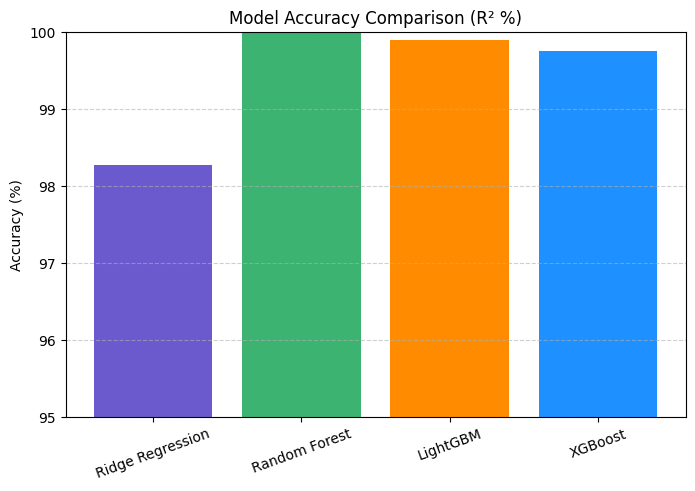

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(results_df["Model"], results_df["R2 (%)"], color=["#6A5ACD","#3CB371","#FF8C00","#1E90FF"])
plt.title("Model Accuracy Comparison (R² %)")
plt.ylabel("Accuracy (%)")
plt.ylim(95, 100)
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [ ]:
print("\n🎯 Training Stacking Ensemble...")
from sklearn.linear_model import RidgeCV

estimators = [
    ('rf', RandomForestRegressor(n_estimators=50, max_depth=15, n_jobs=-1, random_state=42)),  # Reduced
    ('lgb', LGBMRegressor(n_estimators=100, learning_rate=0.1, n_jobs=-1, random_state=42, verbose=-1)),  # Reduced
    ('xgb', XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, n_jobs=-1, tree_method='hist', random_state=42, verbosity=0))  # Reduced
]

# Final estimator (meta-learner)
final_estimator = Ridge(alpha=1.0)

# Create stacking regressor
print("  Fitting base models (this may take a few minutes)...")
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=final_estimator, cv=3)  # Reduced cv from 5 to 3
stacking_regressor.fit(X_train, y_train)

print("✓ Stacking ensemble trained!")

# Evaluate stacking
y_pred_stacking = stacking_regressor.predict(X_test)
res_stacking = eval_preds("Stacking Ensemble", y_test, y_pred_stacking)


🎯 Training Stacking Ensemble...
  Fitting base models (this may take a few minutes)...
✓ Stacking ensemble trained!
Stacking Ensemble: MAE=55,688, RMSE=380,251, R2=0.9994


In [ ]:
print("\n📈 Feature Importance (LightGBM):")
imp = pd.Series(lgb.feature_importances_, index=X.columns).sort_values(ascending=False)
print(imp.head(15))

# Save the stacking model as the final pipeline
print("\n💾 Saving final pipeline model...")
pipeline_path = "backend/models/pipeline_v1.pkl"
os.makedirs(os.path.dirname(pipeline_path), exist_ok=True)
joblib.dump(stacking_regressor, pipeline_path)
print(f"✓ Model saved to: {pipeline_path}")

# Also save scaler and features list for later use
joblib.dump(scaler, "backend/models/scaler.pkl")
joblib.dump(features, "backend/models/features.pkl")
print("✓ Scaler and features list saved")


📈 Feature Importance (LightGBM):
bhk                   843
price_per_bath        702
price_per_bhk         418
area_per_bhk          232
price_dev_locality    222
area_num              190
dist_city_center      183
demand_density        129
city_Delhi             24
is_furnished           18
is_apartment           17
city_Chennai           12
city_Bangalore          5
loc_Paschim Vihar       3
area_cat_medium         2
dtype: int32

💾 Saving final pipeline model...
✓ Model saved to: backend/models/pipeline_v1.pkl
✓ Scaler and features list saved



📊 Visualizing top features...


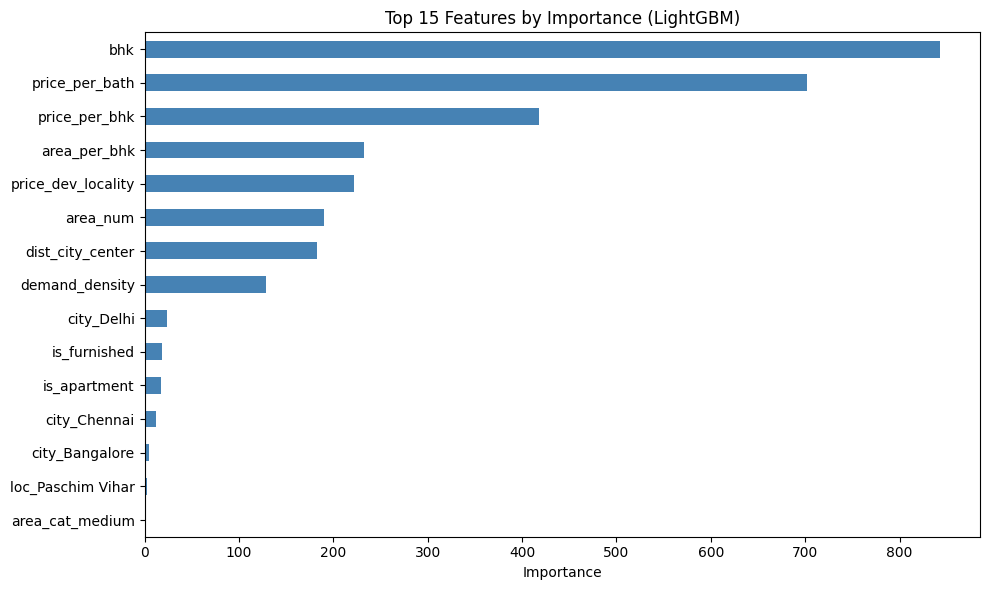


✨ Training complete! Pipeline ready for deployment.


In [ ]:
import matplotlib.pyplot as plt
print("\n📊 Visualizing top features...")
imp.head(15).plot(kind='barh', figsize=(10,6), color='steelblue')
plt.gca().invert_yaxis()
plt.title("Top 15 Features by Importance (LightGBM)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

print("\n✨ Training complete! Pipeline ready for deployment.")

In [ ]:
import nbformat

notebook_path = '/content/RE_train.ipynb'

with open(notebook_path, 'r', encoding='utf-8') as f:
    notebook_content = f.read()

nb = nbformat.reads(notebook_content, as_version=4)

code_cells = []
for cell in nb.cells:
    if cell.cell_type == 'code':
        code_cells.append(cell.source)

for i, code in enumerate(code_cells):
    print(f"### Code Cell {i+1}\n")
    print(f"```python\n{code}\n```\n")

### Code Cell 1

```python
import os
import sys

# Set working directory to project root (for Jupyter notebooks, use os.getcwd())
project_root = r"C:\Users\SOUMIK\Downloads\infosys_internship-main\infosys_internship-main"
os.chdir(project_root)
print(f"✓ Working directory: {os.getcwd()}")

import pandas as pd
import numpy as np

# Load the cleaned dataset (local file)
cleaned_file = "cleaned_indian_property.csv"
if not os.path.exists(cleaned_file):
    print(f"❌ Error: {cleaned_file} not found.")
    print(f"   Please run: python clean_dataset.py")
    sys.exit(1)

df = pd.read_csv(cleaned_file, encoding="latin1")
print(f"✓ Loaded {cleaned_file}: {df.shape}")
```

### Code Cell 2

```python
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_mod